<a href="https://colab.research.google.com/github/mz-zarei/CGAN-Augmentation/blob/main/CGAN_data_augmentation_WA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libs**

In [1]:
import warnings
warnings.filterwarnings('ignore')

import nbeb
import importlib
import numpy as np
import random
import seaborn as sns
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import kendalltau, pearsonr, spearmanr
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy import vstack
from numpy.random import randn
from numpy.random import randint
from keras.datasets.mnist import load_data
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from keras.initializers import RandomNormal
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten, BatchNormalization
from keras.layers import Conv2D, Conv1D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU, ELU, ReLU, concatenate
from keras.layers import Dropout
from matplotlib import pyplot
from keras import Input, Model
import keras
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.distributions.empirical_distribution import ECDF
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt


In [352]:
#### GAN training Functions
# define the standalone discriminator model
def define_discriminator():
    y = Input(shape=(x_size,), dtype='float')
    y_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(y)

    label = Input(shape=(1,))
    label_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(label)

    concat = concatenate([y_output, label_output])
    concat = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
    concat = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
    validity = Dense(1, activation="sigmoid", kernel_initializer=random_uniform)(concat)

    model = Model(inputs=[y, label], outputs=validity)

    # compile model
    opt = Adam(learning_rate=dis_lr, beta_1=0.5, decay=dis_dec)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, in_shape=1):
    y = Input(shape=in_shape, dtype='float')
    y_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(y)

    noise = Input(shape=(latent_dim,))
    noise_output = Dense(100, activation=activation, kernel_initializer=kerner_initializer)(noise)

    concat = concatenate([y_output, noise_output])

    output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(concat)
    output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(output)
    output = Dense(50, activation=activation, kernel_initializer=kerner_initializer)(output)
    output = Dense(x_size, activation="relu", kernel_initializer=random_normal)(output)

    model = Model(inputs=[noise, y], outputs=output)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get output from the generator model
    gen_output = g_model.output
    # connect output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(learning_rate=gen_lr, beta_1=0.5, decay=gen_dec)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

# load and prepare training set
def load_real_samples(x_train,y_train):

    trainX = x_train.to_numpy()
    trainY = y_train.to_numpy()

    return [trainX, trainY]

# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset[0].shape[0], n_samples)
    # retrieve selected images
    X, labels = dataset[0][ix], dataset[1][ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return [X, labels], y

# generate emipircal distribution of real y samples
def generate_y_labels(y_train, size):
    y_train = y_train.tolist()

    min_y = min(y_train)
    max_y = max(y_train)

    y_list = range(min_y, max_y+1)
    y_prob_list = []


    for y in y_list:
        y_prob = y_train.count(y)/len(y_train)
        y_prob_list.append(y_prob)

    for i, prob in enumerate(y_prob_list):
        if prob == 0:
            y_prob_list[i] = y_prob_list[len(y_prob_list)-1]
    
    y_prob_list_normalized = [float(i)/sum(y_prob_list) for i in y_prob_list]


    sample_label = np.random.choice(y_list, size=size, p=y_prob_list_normalized)
    return sample_label

# Cure plot
def CURE(data, ax, x_label, plot_label, ls='-', y_name='Obs', x='Ftot', y_pred='y_pred',boundry=True):
    data.sort_values(by=x, ascending=True, inplace=True)
    data.reset_index(drop=True, inplace=True)

    data['res'] = data[y_pred] - data[y_name]
    data['res_sq'] = (data[y_pred] - data[y_name])**2

    data['e1'] = data['res'].cumsum()
    data['e2'] = data['res_sq'].cumsum()
    data['e3'] = data['e2']*((1 - data['e2']/data['e2'][len(data['e2'])-1]))
    if boundry == True:
        ax.plot(data[x], data['e3'], linestyle = 'dotted',label="2$\sigma$")
        ax.plot(data[x], -data['e3'], linestyle = 'dotted',label="-2$\sigma$")
    ax.plot(data[x], data['e1'], linestyle = ls, label = plot_label)
    ax.legend(loc='upper right',fontsize=10)
    ax.set_xlabel(x_label)
    ax.set_ylabel('CURE')
   


# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples) #randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim)
    # generate labels
    labels = np.random.choice(max, size=n_samples, p=prob)
    return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    # predict outputs
    samples = generator.predict([z_input, labels_input])
    # create class labels
    y = zeros((n_samples, 1))
    return [samples, labels_input], y

# create a line plot of loss for the gan and save to file
def plot_history(d1_hist, d2_hist, g_hist):
    # plot history
    pyplot.plot(d1_hist, label='Dis loss real')
    pyplot.plot(d2_hist, label='Dis loss fake')
    pyplot.plot(g_hist, label='Gen loss')
    pyplot.legend()
    pyplot.savefig('plot_line_plot_loss.png')

# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=100):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)
    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    # save the generator model tile file
    filename = '/content/drive/MyDrive/GAN_regression/ganRegression/CGAN_augment_models/WA_generator_model_%03d.h5' % (epoch + 1)
    g_model.save(filename)

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # lists for keeping track of loss
    d1_hist, d2_hist, g_hist = list(), list(), list()
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate 'fake' examples
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))
            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)

        d1_hist.append(d_loss1)
        d2_hist.append(d_loss2)
        g_hist.append(g_loss)
        # evaluate the model performance, sometimes
        if (i+1) % 200 == 0:
            summarize_performance(i, g_model, d_model, dataset, latent_dim)
            print('Epoch: %d, dLoss real = %.3f, dLoss fake = %.3f, gLoss = %.3f' % (i+1, d_loss1, d_loss2, g_loss))
    plot_history(d1_hist, d2_hist, g_hist)
    return d1_hist, d2_hist, g_hist




seed = 40
random.seed(seed)
np.random.seed(seed)
kerner_initializer = keras.initializers.he_normal(seed=seed)
random_uniform = keras.initializers.RandomUniform(seed=seed)
random_normal = keras.initializers.RandomNormal(seed=seed)
latent_dim, x_size = 4, 4
activation = "elu"

# **Preparing Crash Data**

In [48]:
## Importing Data
y_name = 'FI'
Path_to_data = "/content/drive/MyDrive/GAN_regression/ganRegression/UrbanFreeWay4laneDivided.xlsx"

all_data = pd.read_excel(Path_to_data)
print(f'Columns: {all_data.columns}')
all_data.sort_values(by=['ID'])

# data['TERRAIN'].describe()
all_data.groupby('year').FI.describe().round(2)
# data.describe().round(2)

Columns: Index(['RURURB', 'TERRAIN', 'LSHLDWID', 'LSHL_WD2', 'MEDWID', 'NO_LANES',
       'RSHLDWID', 'RSHL_WD2', 'SEG_LNG', 'lanewid', 'AADT', 'year', 'RSW_r',
       'LSW_r', 'Divided', 'rodwycls', 'Class', 'Class2', 'ID', 'PDO', 'Fatal',
       'Injury', 'FI', 'TotalCrash'],
      dtype='object')


,count,mean,std,min,25%,50%,75%,max
year,,,,,,,,
2012,3085.0,0.22,0.76,0.0,0.0,0.0,0.0,17.0
2013,3085.0,0.20,0.71,0.0,0.0,0.0,0.0,11.0
2014,3085.0,0.23,0.82,0.0,0.0,0.0,0.0,15.0
2015,3085.0,0.26,0.87,0.0,0.0,0.0,0.0,19.0
2016,3085.0,0.29,0.97,0.0,0.0,0.0,0.0,23.0
2017,3085.0,0.28,0.85,0.0,0.0,0.0,0.0,16.0


In [49]:
# Keep data for the last two years
data = all_data[all_data["year"] < 2014].copy()
data = data.reset_index(drop=True)

# Feature transformations
data['log_AADT'] = np.log(data["AADT"])
data['SEG_LNG'] = data['SEG_LNG'] * 1609                    # mile to m
data['log_L'] = np.log(data['SEG_LNG'])
data['MED_dummy'] = [1 if m > 10 else 0 for m in data.MEDWID.values]
data['LSW_dummy'] = [1 if m > 0 else 0 for m in data.LSHLDWID.values]
data['RSW_dummy'] = [1 if m > 0 else 0 for m in data.RSHLDWID.values]

# Terrain_one_hot = pd.get_dummies(data.TERRAIN, prefix='TERRAIN')
# data[Terrain_one_hot.columns.to_list()] = Terrain_one_hot


# Split train and test data sets
seed = 50
random.seed(50)
np.random.seed(50)

test_ids = random.sample(set(data['ID'].unique()), 585)
train_data_all = data.loc[~data['ID'].isin(test_ids)].copy()
test_data = data.loc[data['ID'].isin(test_ids)].copy()

data[['LSHLDWID','MEDWID','RSHLDWID','AADT', 'SEG_LNG', 'FI']].describe().round(2)

,LSHLDWID,MEDWID,RSHLDWID,AADT,SEG_LNG,FI
count,6170.00,6170.00,6170.00,6170.00,6170.00,6170.00
mean,2.15,40.07,8.55,44440.86,134.75,0.21
std,2.47,41.61,3.55,26958.45,190.94,0.74
min,0.00,2.00,0.00,4328.00,16.09,0.00
25%,0.00,16.00,10.00,24315.00,32.18,0.00
50%,0.00,40.00,10.00,40808.00,64.36,0.00
75%,4.00,48.00,10.00,58206.00,160.90,0.00
max,22.00,750.00,24.00,170716.00,3250.18,17.00


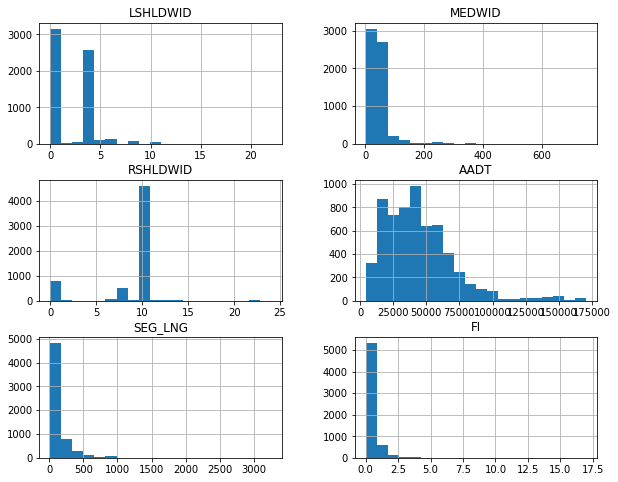

In [50]:
ax = data[['LSHLDWID', 'MEDWID', 'RSHLDWID','AADT', 'SEG_LNG', 'FI']].hist(bins = 20, figsize=(10, 8))

# **Fit NB model (Truth)**

In [146]:
x_features = ['MED_dummy','RSW_dummy','log_AADT', 'log_L']
significant_features = nbeb.backward_regression(data, x_features, 
                                            y_name=y_name, threshold_out=0.05, 
                                            verbose=False)
NB_model_true, alpha_true  = nbeb.fitNB(data, significant_features, y_name=y_name)
test_pred_true = NB_model_true.predict(sm.add_constant(test_data[significant_features]))

print(f"Dispersion: {alpha_true:0.2f}")
print(NB_model_true.summary2())

Dispersion: 0.94
               Results: Generalized linear model
Model:              GLM              AIC:            5317.3598  
Link Function:      log              BIC:            -51121.5757
Dependent Variable: FI               Log-Likelihood: -2653.7    
Date:               2022-07-28 15:51 LL-Null:        -3451.5    
No. Observations:   6170             Deviance:       2683.2     
Df Model:           4                Pearson chi2:   6.49e+03   
Df Residuals:       6165             Scale:          1.0000     
Method:             IRLS                                        
----------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
----------------------------------------------------------------
const        -20.4131   0.7567 -26.9749 0.0000 -21.8963 -18.9299
MED_dummy     -0.6857   0.1084  -6.3225 0.0000  -0.8982  -0.4731
RSW_dummy     -0.4213   0.1088  -3.8720 0.0001  -0.6346  -0.2081
log_AADT       1.4307   

# **Train CGAN and Fit NB models on Augmented/non-Augmented Data**

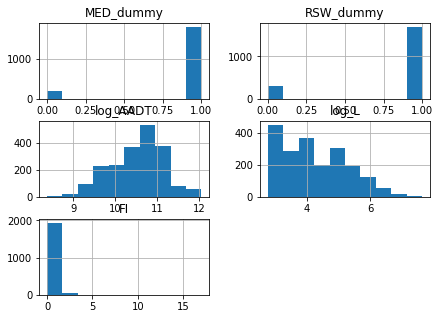

In [343]:
# Sample From Train Data
sample_siza = 1000
x_features = ['MED_dummy','RSW_dummy','log_AADT', 'log_L']

train_ids = random.sample(set(train_data_all['ID'].unique()), sample_siza)
train_data = train_data_all.loc[train_data_all['ID'].isin(train_ids)].copy().reset_index(drop=True)
# display(train_data.describe().round(3))
ax2 = train_data[x_features + ['FI']].hist(bins = 10, figsize=(7, 5))

In [344]:
# Fit NB on non-Augmented Sample
x_features = ['MED_dummy','RSW_dummy','log_AADT', 'log_L']
significant_features = nbeb.backward_regression(train_data, x_features, 
                                            y_name=y_name, threshold_out=0.05, 
                                            verbose=False)
# significant_features = x_features
NB_model, alpha  = nbeb.fitNB(train_data, significant_features, y_name=y_name)
test_pred_nonAugmented = NB_model.predict(sm.add_constant(test_data[significant_features]))

# Evaluation
## predictive metrics on test set
mae_non_augmented  = mean_absolute_error(test_pred_true, test_pred_nonAugmented)
mape_non_augmented = nbeb.MAPE(test_pred_true.values, test_pred_nonAugmented.values)
rmse_non_augmented  = mean_squared_error(test_pred_true, test_pred_nonAugmented)**0.5
## accuracy of dispersion
mape_alpha_non_augmented = abs(alpha_true - alpha)/alpha_true

print(f"Dispersion: {alpha:0.3f}, MAPE alpha: {mape_alpha_non_augmented}") 
print(f"MAE: {mae_non_augmented:0.3f}, RMSE: {rmse_non_augmented:0.3f}, MAPE: {mape_non_augmented:0.3f}")
print(NB_model.summary2())

Dispersion: 1.092, MAPE alpha: 0.1635445298465139
MAE: 0.016, RMSE: 0.042, MAPE: 0.091
               Results: Generalized linear model
Model:              GLM              AIC:            1660.4274  
Link Function:      log              BIC:            -14340.3046
Dependent Variable: FI               Log-Likelihood: -825.21    
Date:               2022-07-28 17:51 LL-Null:        -1065.8    
No. Observations:   2000             Deviance:       823.50     
Df Model:           4                Pearson chi2:   2.26e+03   
Df Residuals:       1995             Scale:          1.0000     
Method:             IRLS                                        
----------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
----------------------------------------------------------------
const        -19.0780   1.3107 -14.5557 0.0000 -21.6469 -16.5091
MED_dummy     -0.5726   0.2118  -2.7034 0.0069  -0.9877  -0.1575
RSW_dummy     -0.64

In [ ]:
gen_lr, dis_lr, gen_dec, dis_dec, n_epochs, n_batch = 0.001, 0.001, 0.001, 0, 1000, int(500) 

# train data
x_train = train_data[x_features].copy()
y_train = train_data[y_name].copy()


  
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load data
dataset = load_real_samples(x_train,y_train)
# find empirical distribution for crash count
n, max = len(dataset[1]), dataset[1].max()+1
prob = np.array([1/n if np.count_nonzero(dataset[1]==i)==0 else np.count_nonzero(dataset[1]==i)/n for i in range(max)])
## fixing prob sum to be 1
prob /= sum(prob)

# # train model
d1_hist, d2_hist, g_hist = train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs, n_batch)

>Accuracy real: 40%, fake: 54%


Epoch: 200, dLoss real = 0.699, dLoss fake = 0.699, gLoss = 0.705


In [351]:
latent_points = generate_latent_points(latent_dim, 4000-sample_siza*2)
latent_points

[array([[ 1.7423265 ,  1.45889567,  0.25569345,  0.10666182],
        [-0.73709124, -0.39193051,  0.68243698, -0.60505572],
        [ 0.3883903 ,  0.31456763, -0.31527066,  0.95915535],
        ...,
        [ 0.49548127,  1.60057019, -0.87601914, -1.20817507],
        [-0.2458299 , -0.10691995, -0.20091994, -0.98958117],
        [ 1.5365163 , -1.42667385,  0.0661576 ,  0.47029197]]),
 array([0, 1, 1, ..., 0, 0, 0])]

In [309]:
# load GAN model
model_path = '/content/drive/MyDrive/GAN_regression/ganRegression/CGAN_augment_models/'
model = load_model(model_path + 'WA_generator_model_1000.h5')
dataset = load_real_samples(x_train, y_train)

# generate latent points
latent_points = generate_latent_points(latent_dim, 4000-sample_siza*2)
# generate samples
Fake_data = model.predict(latent_points)
fake = pd.DataFrame(Fake_data, columns=x_features)
fake[y_name] = latent_points[1]
fake['MED_dummy'] =  [1 if m > 0.5 else 0 for m in fake.MED_dummy.values]
fake['RSW_dummy'] =  [1 if m > 0.5 else 0 for m in fake.RSW_dummy.values]


## NB model with real and fake data
# Find significant features
concat_data = pd.concat([train_data, fake])
x_train_augmented = concat_data[x_features]
y_train_augmented = concat_data[y_name]
significant_features = nbeb.forward_regression(concat_data, x_features, y_name=y_name, threshold_in=0.05, verbose=False) 

NB_model_augmented, alpha_augmented = nbeb.fitNB(concat_data, significant_features, y_name=y_name)

test_pred_Augmented = NB_model_augmented.predict(sm.add_constant(test_data[significant_features]))

# Evaluation
## predictive metrics on test set
mae_augmented  = mean_absolute_error(test_pred_true, test_pred_Augmented)
mape_augmented = nbeb.MAPE(test_pred_true.values, test_pred_Augmented.values)
rmse_augmented  = mean_squared_error(test_pred_true, test_pred_Augmented)**0.5
## accuracy of dispersion
mape_alpha_augmented = abs(alpha_true - alpha_augmented)/alpha_true

print(f"Dispersion: {alpha_augmented:0.3f}, MAPE alpha: {mape_alpha_augmented:0.3f}") 
print(f"MAE: {mae_augmented:0.3f}, RMSE: {rmse_augmented:0.3f}, MAPE: {mape_augmented:0.3f}")
print(NB_model_augmented.summary2())


Dispersion: 0.327, MAPE alpha: 0.652
MAE: 0.040, RMSE: 0.107, MAPE: 0.163
               Results: Generalized linear model
Model:              GLM              AIC:            3423.3940  
Link Function:      log              BIC:            -31132.4136
Dependent Variable: FI               Log-Likelihood: -1706.7    
Date:               2022-07-28 17:21 LL-Null:        -2366.6    
No. Observations:   4000             Deviance:       2002.3     
Df Model:           4                Pearson chi2:   5.21e+03   
Df Residuals:       3995             Scale:          1.0000     
Method:             IRLS                                        
----------------------------------------------------------------
              Coef.   Std.Err.    z     P>|z|   [0.025   0.975] 
----------------------------------------------------------------
const        -18.2487   0.6784 -26.8991 0.0000 -19.5784 -16.9190
log_AADT       1.2719   0.0609  20.8978 0.0000   1.1527   1.3912
log_L          0.8144   0.0361  

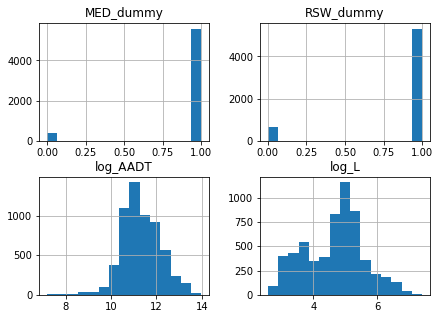

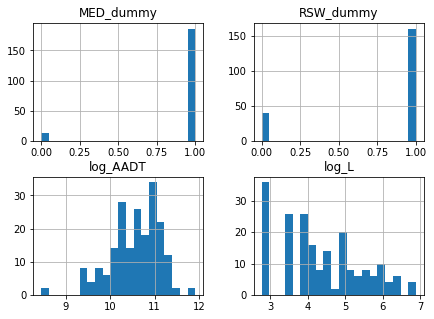

In [153]:
ax1 = fake[x_features].hist(bins = 15, figsize=(7, 5))
ax2 = train_data[x_features].hist(bins = 20, figsize=(7, 5))